In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import pandas as pd

In [13]:
fittedPCR = pd.read_csv('~/Documents/Github/pcr-profile/PCR_curve_summary.csv')
fittedLFD = pd.read_csv('~/Documents/Github/pcr-profile/LFT_curve_summary.csv')
t = fittedPCR['days_since_infection'].to_numpy()
PCRpos = fittedPCR['median'].to_numpy()
LFDpos = fittedLFD['median'].to_numpy()

symponset = 4.84
def infectivity_profile():
    imean = 5.0
    istd = 1.92
    kguess = (istd/imean)**(-1.086)
    cguess = imean / sp.special.gamma(1 + 1/kguess)
    f = stats.weibull_min.pdf(t, kguess, scale=cguess)
    return f

def symp_profile():
    alpha = 4.84**2/2.8**2
    beta = 4.84/2.8**2
    g = stats.gamma.pdf(t, alpha, scale=1/beta)
    return g

def infectivity_scale(ts, tt, td, tpos, Psisol, tisol):
    t_result = tt + td
    t_result = np.append(t_result, ts)
    t_order = np.argsort(t_result)
    t_prob = np.append(tpos, Psisol)
    t_result = t_result[t_order]
    t_prob = t_prob[t_order]
    f_scale = np.ones(len(t))
    Pmissed = 1
    for k in np.arange(len(t_result)):
        Ph = t_prob[k]*Pmissed
        trange = ((t >= t_result[k]) & (t < t_result[k] + tisol))
        f_scale[trange] -= Ph
        Pmissed *= (1 - t_prob[k])
    return f_scale

def infectivity_scale_no_test(ts, Psisol, tisol):
    f_scale = np.ones(len(t))
    trange = (t >= ts)
    f_scale[trange] -= Psisol

    return f_scale
    
def integrate_f(tauf, td, Psisol, tisol, ttype = 'PCR'):
    dt = t[1]-t[0]
    idt = 1/dt
    t0 = np.arange(0,tauf,dt)
    ggen = symp_profile()
    gint = np.zeros(len(t))
    for i in np.arange(len(t)):
        tsh = t[i]
        iprof = infectivity_profile()
        if tauf > 0:
            fint = np.zeros(len(t0))
            for j in np.arange(len(t0)):
                t0h = t0[j]
                tt = np.arange(t0h, np.max(t)-td, tauf)
                itt = np.array(np.round(tt*idt),dtype=np.int)
                if ttype == 'PCR':
                    tpos = PCRpos[itt]
                else:
                    tpos = LFDpos[itt]
                fscale = infectivity_scale(tsh, tt, td, tpos, Psisol, tisol)
                fh = iprof*fscale
                fint[j] = np.trapz(fh,t)
                
            gint[i] = np.trapz(fint,t0)/tauf
        else:
            fscale = infectivity_scale_no_test(tsh, Psisol, tisol)
            fh = iprof*fscale
            gint[i] = np.trapz(fh,t)
    F = np.trapz(ggen*gint,t)
    
    return F

In [14]:
Ttype = ['PCR','PCR','PCR','LFD']
taud = [0,1,2,0]
tauisol = 10.0
Psisol = 0.5
tauf = np.arange(1,15)
Ftest_isol = np.zeros((len(Ttype),len(tauf)))
for i in np.arange(len(Ttype)):
    for j in np.arange(len(tauf)):
        Ftest_isol[i,j] = integrate_f(tauf[j], taud[i], Psisol, tauisol, Ttype[i])
        
        


0 0 0.13264266344287934
0 1 0.23265117250262785
0 2 0.31823920254635296
0 3 0.3843809590405966
0 4 0.4360421016621078
0 5 0.4769898910154624
0 6 0.5092624829122554
0 7 0.5346784454364906
0 8 0.5548508383264881
0 9 0.5711526515192857
0 10 0.5845348481326472
0 11 0.5956950779514361
0 12 0.6051398312109052
0 13 0.6132355321135526
1 0 0.23866120099430915
1 1 0.34457615062785657
1 2 0.4232508254084168
1 3 0.477484065394689
1 4 0.5177485883501651
1 5 0.5484258253516842
1 6 0.5718130130481639
1 7 0.5898451756003861
1 8 0.6040586808480515
1 9 0.6154848895863768
1 10 0.6248458064576642
1 11 0.6326483613243118
1 12 0.6392507641141607
1 13 0.6449099903349813
2 0 0.35711878089611465
2 1 0.45594512370817825
2 2 0.5190120855582782
2 3 0.5588427325090211
2 4 0.5871490887848347
2 5 0.607912145270416
2 6 0.6233381581908995
2 7 0.6351362585312259
2 8 0.6443760087740591
2 9 0.6517831076977992
2 10 0.6578461028818072
2 11 0.6628988901609254
2 12 0.6671743545545683
2 13 0.6708390403887674
3 0 0.20678854532

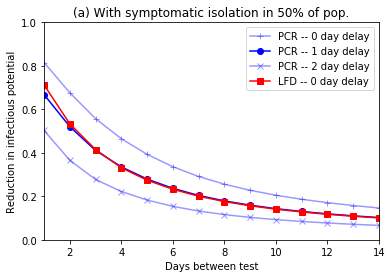

In [15]:
Fbaseline = integrate_f(0, 0, Psisol, tauisol)
Colors = [[0,0,1,0.4],[0,0,1,1],[0,0,1,0.4],[1,0,0,1]]
Style = ['-+','-o','-x','-s']
for i in np.arange(len(Ttype)):
    plt.plot(tauf, 1-(Ftest_isol[i,:]/Fbaseline), Style[i], c=Colors[i], label='%s -- %d day delay'%(Ttype[i],taud[i]))
plt.legend()
plt.xlim(1,14)
plt.ylim(0,1.0)
plt.xlabel('Days between test')
plt.ylabel('Reduction in infectious potential')
plt.title('(a) With symptomatic isolation in 50% of pop.')
plt.savefig('RPI_mean.png')

In [16]:
Ttype = ['PCR','PCR','PCR','LFD']
taud = [0,1,2,0]
tauisol = 10.0
Psisol = 0.0
tauf = np.arange(1,15)
Ftest = np.zeros((len(Ttype),len(tauf)))
for i in np.arange(len(Ttype)):
    for j in np.arange(len(tauf)):
        print(i,j)
        Ftest[i,j] = integrate_f(tauf[j], taud[i], Psisol, tauisol, Ttype[i])

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13


[[0.14997972 0.28005447 0.3982854  0.49322168 0.56914445 0.63038441
  0.67925238 0.71801483 0.74888577 0.7738819  0.79441641 0.81154458
  0.82604053 0.83846602]
 [0.28224483 0.42768886 0.54176517 0.62330231 0.68497125 0.73256163
  0.76912773 0.79743103 0.81978919 0.83777953 0.85252225 0.86481132
  0.87521024 0.88412365]
 [0.44234143 0.58509489 0.68101654 0.74338573 0.78831668 0.82156017
  0.84636987 0.865395   0.88031125 0.89227351 0.90206595 0.91022689
  0.91713235 0.92305133]
 [0.24545085 0.42398648 0.54688552 0.63604352 0.69788552 0.74365284
  0.77856096 0.80567892 0.82708777 0.84433972 0.85848461 0.87027663
  0.88025513 0.88880818]]


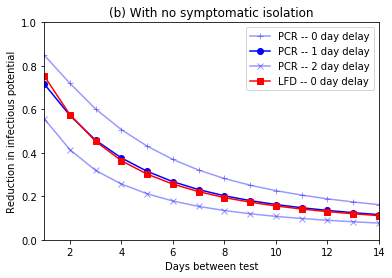

In [17]:
print(Ftest)
Fbaseline = integrate_f(0, 0, Psisol, tauisol)
Colors = [[0,0,1,0.4],[0,0,1,1],[0,0,1,0.4],[1,0,0,1]]
Style = ['-+','-o','-x','-s']
for i in np.arange(len(Ttype)):
    plt.plot(tauf, 1-(Ftest[i,:]/Fbaseline), Style[i], c=Colors[i], label='%s -- %d day delay'%(Ttype[i],taud[i]))
plt.legend()
plt.xlim(1,14)
plt.ylim(0,1.0)
plt.xlabel('Days between test')
plt.ylabel('Reduction in infectious potential')
plt.title('(b) With no symptomatic isolation')
plt.savefig('RPI_mean_nosymp.png')